# 数据读入模块

In [76]:
import pandas as pd

global train_data,test_data

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [77]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [78]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

In [79]:
train_data['nan_num']=(train_data==0).astype(int).sum(axis=1)
test_data['nan_num']=(test_data==0).astype(int).sum(axis=1)

In [80]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_train.csv')

    ways_1 = []
    temp = list(temp_test.columns)

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        if i % 1000 == 0:
            print(i)
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count'))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean'))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum'))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum'))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000

## 处理NAN

In [81]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [82]:
df_train = delnan(train_data)
df_test = delnan(test_data)

In [83]:
#df_train.to_csv('data.csv')

## 处理-99

In [84]:
df_train.replace(-99,-1,inplace=True)
df_test.replace(-99,-1,inplace=True)

## 主成分分析（效果不好）

In [85]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]

## 处理分类变量

In [86]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [87]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [88]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [89]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [90]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]
loan_pca_col=[i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## 设置哪些x作为模型自变量输入

In [91]:
x_col = basic_col+['is_judicial']+loan_col

In [92]:
# df_train.drop(columns=drop_col)

In [93]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')

# 训练模型

## 超参数

In [94]:
N = 1000
num_round = 100
local_test_size=3000

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.5,0.7]
subsample=[0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5,6,10]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [95]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0
important_x_seq=[]

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    
    if False:
        pic=xgb.plot_importance(bst,max_num_features=50)
        temp=pic.get_ymajorticklabels()
        important_x=[str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq+=important_x

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

1:0.6378779840848806
2:0.6576498517585683
3:0.6867879907500213
4:0.660085139085382
5:0.630480310935608
6:0.6370058030113357
7:0.687121998417227
8:0.5
9:0.6651230540525389
10:0.6607056551724138
11:0.625093560490241
12:0.67270557980982
13:0.6858046492885936
14:0.7054685108662382
15:0.628644489480226
16:0.6645292947216986
17:0.6168507431373941
18:0.6488338374983141
19:0.64389818055739
20:0.6229732070388603
21:0.6848980842911877
22:0.6472101984797297
23:0.6158739599155375
24:0.6442461697621664
25:0.6407714257735551
26:0.6895318072249372
27:0.6252093183609141
28:0.6575338642505042
29:0.6478192951095222
30:0.6724902191721718
31:0.6424949506293771
32:0.667893500611823
33:0.6225949657623147
34:0.6794527431977282
35:0.671861489057684
36:0.6614576773431026
37:0.5
38:0.6315587067077472
39:0.6783364266645148
40:0.6479268322461738
41:0.6831476807089919
42:0.6373068601247296
43:0.5890368158721253
44:0.6404638335701136
45:0.6884635005659445
46:0.6800156390607036
47:0.6192188680191261
48:0.66518288265

In [96]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.637878,0.713693,0.612776,0.3,3,0.10,0.8,binary:logistic,1,auc,0.6,0.2,3.0,3,gpu_hist,0
1,0.657650,0.760300,0.658359,0.3,4,0.10,0.6,binary:logistic,1,auc,0.4,0.2,1.0,1,gpu_hist,0
2,0.686788,0.930842,0.652193,0.5,4,0.10,0.8,binary:logistic,20,auc,0.7,0.0,1.0,4,gpu_hist,0
3,0.660085,0.889199,0.702859,0.5,6,0.10,0.7,binary:logistic,1,auc,0.7,0.8,3.0,5,gpu_hist,0
4,0.630480,0.908674,0.643445,0.7,6,0.06,0.6,binary:logistic,30,auc,0.4,0.2,1.5,5,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.622318,0.944699,0.648533,0.7,5,0.10,0.5,binary:logistic,3,auc,0.6,0.8,1.5,2,gpu_hist,0
996,0.637015,0.972041,0.680103,0.5,7,0.10,0.7,binary:logistic,10,auc,0.4,0.6,1.5,1,gpu_hist,0
997,0.687593,0.895487,0.685252,0.3,5,0.06,0.8,binary:logistic,10,auc,0.6,0.6,1.0,2,gpu_hist,0
998,0.669763,0.785314,0.658952,0.3,3,0.06,0.7,binary:logistic,6,auc,0.7,0.8,1.0,2,gpu_hist,0


In [97]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

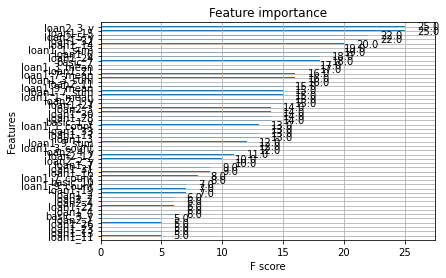

In [98]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [99]:
important_x

['loan2_3_y',
 'loan1_15',
 'loan2_5_y',
 'loan1_32',
 'loan1_14',
 'loan1_1_sum',
 'loan1_6',
 'loan1_24',
 'basic_7',
 'loan1_3_mean',
 'loan1_21',
 'loan1_7_mean',
 'loan1_3_sum',
 'loan2_11',
 'loan1_9_mean',
 'loan1_7_sum',
 'loan1_1_mean',
 'loan2_1_y',
 'loan1_27',
 'loan2_3',
 'loan1_30',
 'loan1_28',
 'basic_1_y',
 'loan1_1_count',
 'loan1_33',
 'loan1_17',
 'loan1_3',
 'loan1_9_sum',
 'loan1_3_count',
 'loan2_4_y',
 'loan2_12',
 'loan2_2_y',
 'loan1_7',
 'loan1_31',
 'loan1_16',
 'loan1_7_count',
 'basic_10',
 'loan1_9_count',
 'loan1_19',
 'loan1_2',
 'loan2_7',
 'loan2_4',
 'loan1_22',
 'loan1_4',
 'basic_3_y',
 'loan2_1',
 'loan1_26',
 'loan1_23',
 'loan1_13',
 'loan1_11']

In [100]:
#pd.value_counts(important_x_seq)

* basic_7:年龄
* 

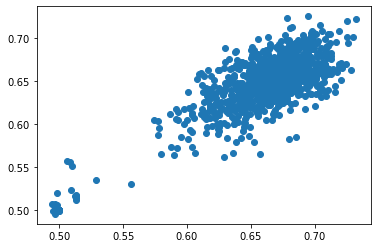

In [101]:
import matplotlib.pyplot as plt
plt.scatter(info_df['local_test_auc'],info_df['test_auc'])

# 输出模块

In [103]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 100
    n=min(N,n)

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
#print("平均之后AUC为",local_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前100个auc为[0.7324206896551724, 0.7297241379310345, 0.7284724137931035, 0.7260741379310345, 0.7253655172413793, 0.7251344827586207, 0.7247068965517242, 0.7210793103448276, 0.720451724137931, 0.7204, 0.7193551724137931, 0.7190931034482758, 0.7190103448275862, 0.7175413793103448, 0.7166724137931034, 0.7159551724137931, 0.7158931034482758, 0.714396551724138, 0.7130293103448276, 0.7129724137931035, 0.7124206896551725, 0.7123689655172414, 0.7123051724137931, 0.7116137931034483, 0.7113551724137931, 0.7104275862068965, 0.7104034482758621, 0.7101413793103448, 0.7100931034482758, 0.7097896551724138, 0.7097551724137932, 0.7095103448275862, 0.7095, 0.7091724137931035, 0.7089310344827586, 0.7087689655172413, 0.7086775862068966, 0.7085413793103448, 0.7085155172413793, 0.7084, 0.7083344827586207, 0.7081137931034482, 0.7080379310344828, 0.708003448275862, 0.7077793103448276, 0.707246551724138, 0.707148275862069, 0.7070896551724138, 0.7068086206896552, 0.7063310344827586, 0.7062379310344827, 0.7058

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用